In [1]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
project_root = Path.cwd().parent.parent  # Assuming notebook is in experiments/notebooks/
sys.path.insert(0, str(project_root))
print(sys.path)
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from experiments.analysis_utils.data_processing import read_directory
from experiments.analysis_utils.visualization import plot_reaction_speed_distribution, plot_token_distribution

['/home/rotsker/PycharmProjects/dg-research-revision', '/home/rotsker/miniconda3/envs/radCAD/lib/python312.zip', '/home/rotsker/miniconda3/envs/radCAD/lib/python3.12', '/home/rotsker/miniconda3/envs/radCAD/lib/python3.12/lib-dynload', '', '/home/rotsker/miniconda3/envs/radCAD/lib/python3.12/site-packages']


In [2]:
from model.utils.seed import initialize_seed
from model.utils.reactions import determine_reaction_time_vector
from model.types.reaction_time import ReactionTime, ModeledReactions

def get_actor_category(**kwargs):
    # Get the length of the first boolean numpy array
    first_key = next(iter(kwargs))
    length = len(kwargs[first_key])
    
    # Create an array of strings initialized with a default value
    actor_category = np.array(['Normal'] * length)
    
    # Apply masks to set corresponding names
    for mask_name, mask in kwargs.items():
        actor_category[mask] = mask_name
    
    return actor_category

def get_abstaining_mask(wallet_df):
    actor_typestr = np.array(wallet_df.type)
    abstaining_mask = np.isin(actor_typestr, ['Contract', 'CEX', 'Custody'])
    return abstaining_mask

def get_institutional_mask(wallet_df, institutional_threshold: float = 3000):
    institutional_mask = wallet_df.total >= institutional_threshold
    return institutional_mask

def get_reaction_time_distribution(wallet_df, 
                                   reactions: ModeledReactions = ModeledReactions.Normal,
                                   institutional_threshold: float = 3000):
    reaction_time_vector = determine_reaction_time_vector(len(wallet_df), reactions)

    institutional_mask = get_institutional_mask(wallet_df, institutional_threshold)
    reaction_time_vector[institutional_mask] = ReactionTime.Slow.value

    abstaining_mask = get_abstaining_mask(wallet_df)
    reaction_time_vector[abstaining_mask] = ReactionTime.NoReaction.value

    actor_category = get_actor_category(
        Institutional=institutional_mask,
        Abstaining=abstaining_mask,
    )

    return reaction_time_vector, actor_category

# Distributions

In [3]:
wallet_tuples = [('original', 'stETH token distribution  - stETH+wstETH holders'),
                 ('centralized', 'centralized_wallet_distribution'),
                 ('decentralized', 'decentralized_wallet_distribution')]
wallet_dfs = []
for name, filename in wallet_tuples:
    wallet_df = pd.read_csv(Path('../../data').joinpath(filename + '.csv'))
    wallet_df['distribution'] = name
    wallet_df['total_token_share'] = wallet_df['total'] / wallet_df['total'].sum()
    wallet_dfs.append(wallet_df)
wallet_df_combined = pd.concat(wallet_dfs, ignore_index=True)


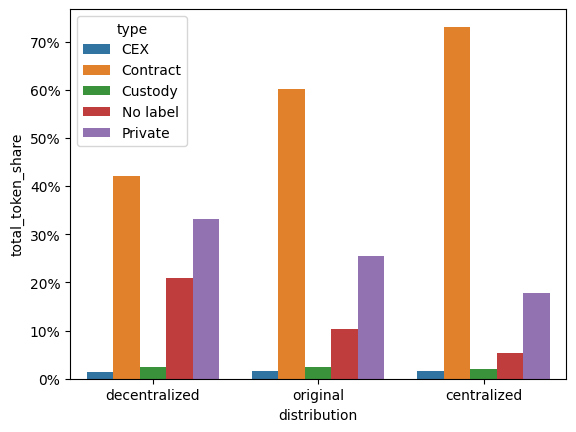

In [4]:
from matplotlib.ticker import PercentFormatter
ax = sns.barplot(
    data=wallet_df_combined.groupby(['distribution', 'type']).total_token_share.sum().reset_index(),
    x='distribution',
    y='total_token_share',
    hue='type',
    order=['decentralized', 'original', 'centralized'])
ax.yaxis.set_major_formatter(PercentFormatter(1))

In [5]:

for distribution in ['decentralized', 'original', 'centralized']:
    mask = wallet_df_combined.distribution == distribution
    initialize_seed(100)
    reaction_time_vector, _ = get_reaction_time_distribution(wallet_df_combined[mask], reactions=ModeledReactions.Normal)
    wallet_df_combined.loc[mask, 'reaction_time_vector'] = reaction_time_vector

wallet_df_combined['reaction_time'] = wallet_df_combined['reaction_time_vector'].map(lambda x: ReactionTime(x).name)

Text(0.5, 1.0, 'Average reaction time')

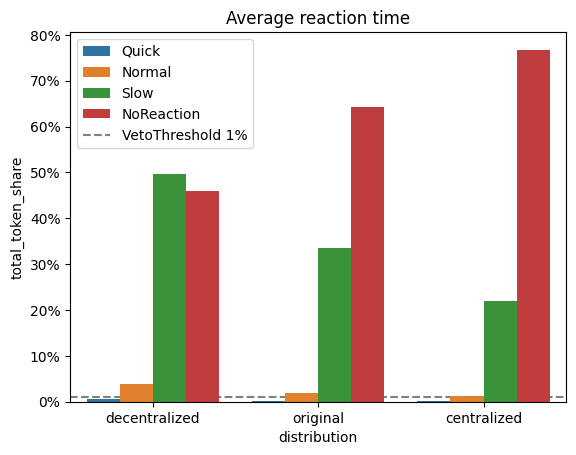

In [6]:
ax =sns.barplot(
    data=wallet_df_combined.groupby(['distribution', 'reaction_time']).total_token_share.sum().reset_index(),
    x='distribution',
    y='total_token_share',
    hue='reaction_time',
    order=['decentralized', 'original', 'centralized'],
    hue_order=['Quick', 'Normal', 'Slow', 'NoReaction'])
ax.yaxis.set_major_formatter(PercentFormatter(1))
xlim = ax.get_xlim()
ax.plot(xlim, [0.01, 0.01], color='gray', linestyle='--', label='VetoThreshold 1%', zorder=0)
ax.set_xlim(xlim)
ax.legend()
ax.set_title('Average reaction time')


Text(0.5, 1.0, 'Average reaction time')

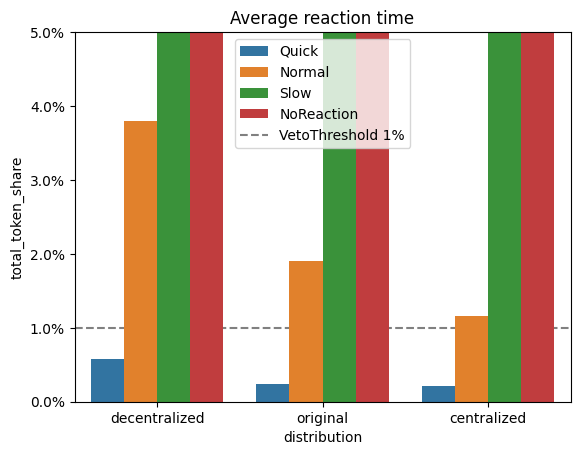

In [7]:
ax = sns.barplot(
    data=wallet_df_combined.groupby(['distribution', 'reaction_time']).total_token_share.sum().reset_index(),
    x='distribution',
    y='total_token_share',
    hue='reaction_time',
    order=['decentralized', 'original', 'centralized'],
    hue_order=['Quick', 'Normal', 'Slow', 'NoReaction'])
ax.yaxis.set_major_formatter(PercentFormatter(1))
ax.set_ylim(0, 0.05)
ax.plot(xlim, [0.01, 0.01], color='gray', linestyle='--', label='VetoThreshold 1%', zorder=0)
ax.set_xlim(xlim)
ax.legend()
ax.set_title('Average reaction time')

Text(0.5, 1.0, 'Average amount of wallets for each reaction time')

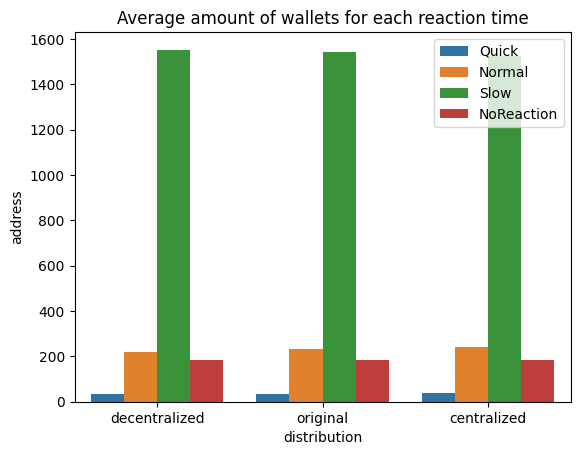

In [8]:
ax = sns.barplot(
    data=wallet_df_combined.groupby(['distribution', 'reaction_time']).address.count().reset_index(),
    x='distribution',
    y='address',
    hue='reaction_time',
    order=['decentralized', 'original', 'centralized'],
    hue_order=['Quick', 'Normal', 'Slow', 'NoReaction'])
ax.set_xlim(xlim)
ax.legend()
ax.set_title('Average amount of wallets for each reaction time')

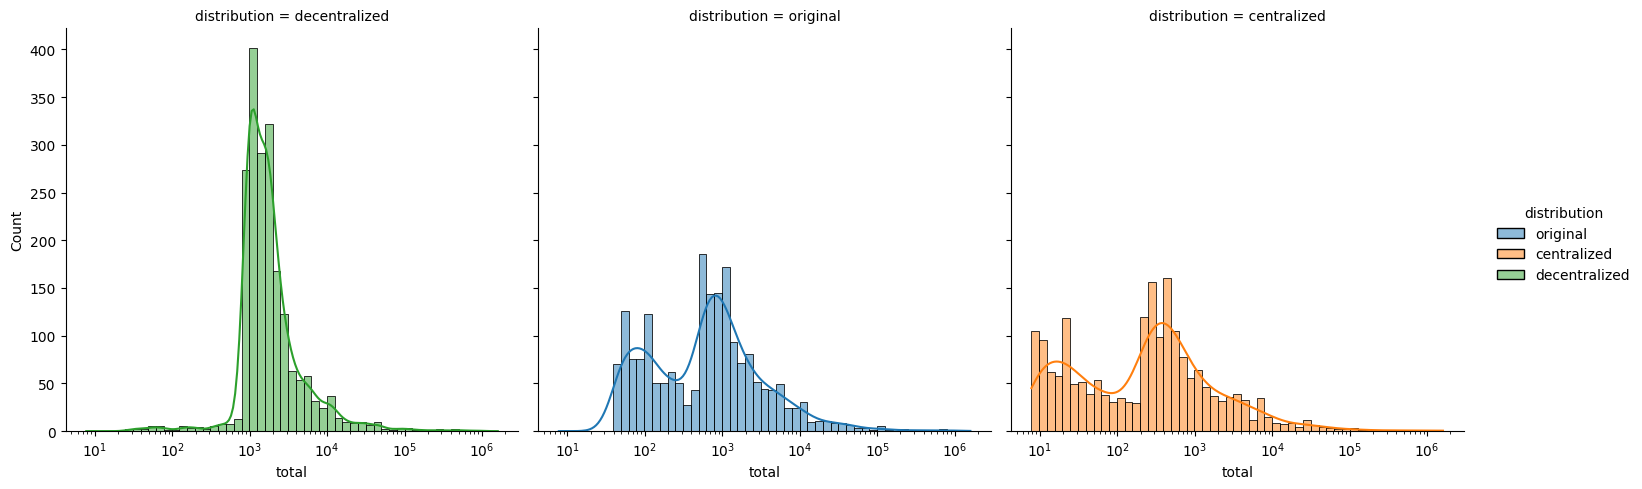

In [9]:
sns.displot(data=wallet_df_combined, x='total', multiple='stack', col='distribution', hue='distribution',log_scale=True, kde=True, kind='hist', col_order=['decentralized', 'original', 'centralized'])


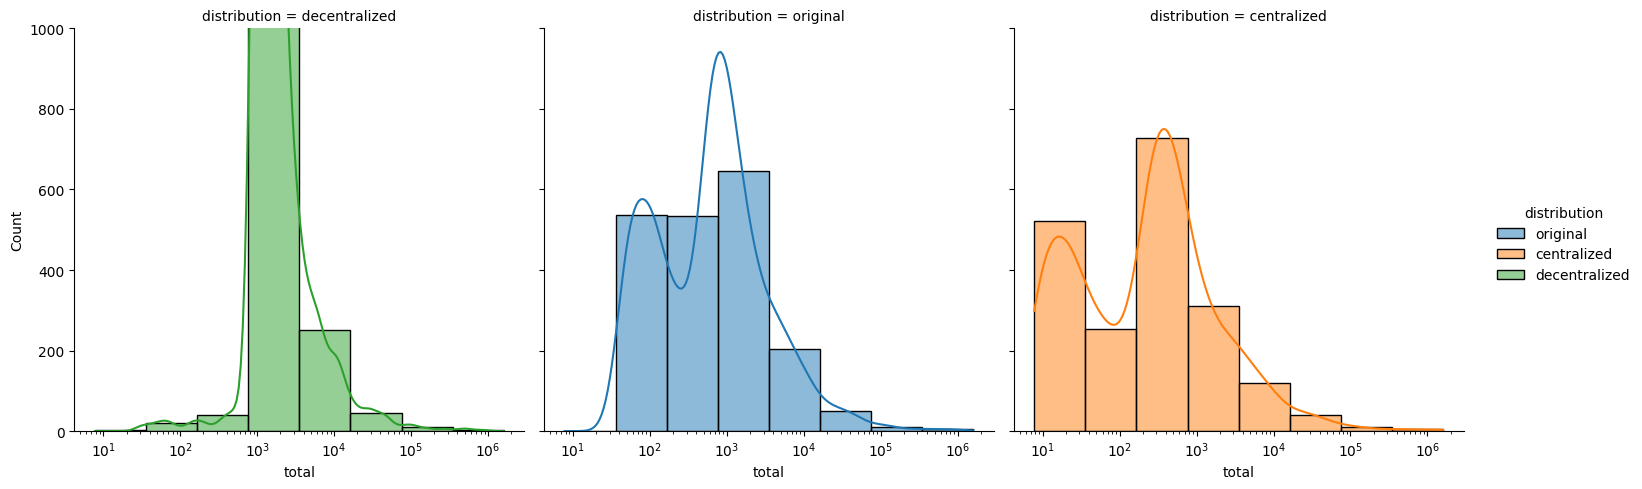

In [10]:
g = sns.displot(data=wallet_df_combined, x='total', multiple='stack', col='distribution', hue='distribution', kde=True, kind='hist', col_order=['decentralized', 'original', 'centralized'], log_scale=True, bins=8)
for ax in g.axes.flat:
    ax.set_ylim(0, 1000)


In [11]:
# Define the bins and labels
bins = [0, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6, float('inf')]
labels = ['[0, 1e1)', '[1e1, 1e2)', '[1e2, 1e3)', '[1e3, 1e4)', '[1e4, 1e5)', '[1e5, 1e6)', '[1e6, inf]']

# Create a new column 'total_bin' to categorize 'total' into bins
wallet_df_combined['total_bin'] = pd.cut(wallet_df_combined['total'], bins=bins, labels=labels, right=False)

# Group by 'distribution' and 'total_bin' and count the number of occurrences
wallet_counts = wallet_df_combined.groupby(['distribution', 'total_bin']).size().unstack(fill_value=0)

wallet_counts.reindex(['decentralized', 'original', 'centralized'])

/tmp/ipykernel_21308/3762015410.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  wallet_counts = wallet_df_combined.groupby(['distribution', 'total_bin']).size().unstack(fill_value=0)


total_bin,"[0, 1e1)","[1e1, 1e2)","[1e2, 1e3)","[1e3, 1e4)","[1e4, 1e5)","[1e5, 1e6)","[1e6, inf]"
distribution,,,,,,,
decentralized,0,17,351,1508,100,10,0
original,0,350,889,641,93,12,1
centralized,117,586,867,348,56,10,2


In [12]:
wallet_df_combined.groupby('distribution').total.sum()

distribution
centralized      8.996417e+06
decentralized    8.996417e+06
original         8.996417e+06
Name: total, dtype: float64

# Cluster A

## Veto Rates

In [51]:
# path_to_runs = Path("../../results/simulations/clusterA_future_proof/")
path_to_runs = Path("../../results/simulations/withdrawal_queue_replacement_execution/")
proposal_df_full, start_data_df_full, timestep_data_df_full = read_directory(path_to_runs.resolve(), pass_directory_name=True)


In [57]:
wallet_tuples = [('original', 'stETH token distribution  - stETH+wstETH holders.csv'),
                 ('centralized', 'centralized_wallet_distribution.csv'),
                 ('decentralized', 'decentralized_wallet_distribution.csv')]
wallet_distribution_map = {filename: name for name, filename in wallet_tuples}
start_data_df_full['wallet_distribution'] = start_data_df_full.wallet_csv_name.map(wallet_distribution_map)

In [68]:
from experiments.analysis_utils.metrics import analyze_veto_timing_by_seals
veto_stats = analyze_veto_timing_by_seals(timestep_data_df_full, start_data_df_full,
                                          proposal_submission_timestep=2,
                                          additional_columns=('wallet_distribution', 'modeled_reactions'))
print("Veto statistics for different wallet distributions and ModeledReactions:")
display(veto_stats[['veto_rate', 'total_runs']])

Veto statistics for different wallet distributions and ModeledReactions:


veto_rate  \
first_seal_rage_quit_support second_seal_rage_quit_support wallet_distribution modeled_reactions               
0.01                         0.1                           centralized         Accelerated        100.000000   
                                                                               Normal              92.452830   
                                                                               Slowed               2.020202   
                                                           decentralized       Accelerated        100.000000   
                                                                               Normal             100.000000   
                                                                               Slowed             100.000000   
                                                           original            Accelerated        100.000000   
                                                                               Normal             100.000000   
                                                                               Slowed              96.969697   

                                                                                                  total_runs  
first_seal_rage_quit_support second_seal_rage_quit_support wallet_distribution modeled_reactions              
0.01                         0.1                           centralized         Accelerated                99  
                                                                               Normal                    106  
                                                                               Slowed                     99  
                                                           decentralized       Accelerated                99  
                                                                               Normal                    106  
                                                                               Slowed                     99  
                                                           original            Accelerated                99  
                                                                               Normal                    106  
                                                                               Slowed                     99

## Times to Veto and RageQuit thresholds

In [107]:
# path_to_runs = Path("../../results/simulations/clusterA_future_proof/")
path_to_runs = Path("../../results/simulations/withdrawal_queue_replacement_no_execution/")
proposal_df_full, start_data_df_full, timestep_data_df_full = read_directory(path_to_runs.resolve(), pass_directory_name=True)
wallet_tuples = [('original', 'stETH token distribution  - stETH+wstETH holders.csv'),
                 ('centralized', 'centralized_wallet_distribution.csv'),
                 ('decentralized', 'decentralized_wallet_distribution.csv')]
wallet_distribution_map = {filename: name for name, filename in wallet_tuples}
start_data_df_full['wallet_distribution'] = start_data_df_full.wallet_csv_name.map(wallet_distribution_map)


In [111]:
from experiments.analysis_utils.metrics import analyze_veto_timing_by_seals
veto_stats = analyze_veto_timing_by_seals(timestep_data_df_full, start_data_df_full,
                                          proposal_submission_timestep=2,
                                          additional_columns=('wallet_distribution', 'modeled_reactions'))
print("Veto statistics for different wallet distributions and ModeledReactions:")
display(veto_stats[['veto_rate', 'hours_median_time_to_veto_hours', 'total_runs']])

Veto statistics for different wallet distributions and ModeledReactions:


veto_rate  \
first_seal_rage_quit_support second_seal_rage_quit_support wallet_distribution modeled_reactions              
0.01                         0.1                           centralized         Accelerated            100.0   
                                                                               Normal                 100.0   
                                                                               Slowed                 100.0   
                                                           decentralized       Accelerated            100.0   
                                                                               Normal                 100.0   
                                                                               Slowed                 100.0   
                                                           original            Accelerated            100.0   
                                                                               Normal                 100.0   
                                                                               Slowed                 100.0   

                                                                                                  hours_median_time_to_veto_hours  \
first_seal_rage_quit_support second_seal_rage_quit_support wallet_distribution modeled_reactions                                    
0.01                         0.1                           centralized         Accelerated                                   75.0   
                                                                               Normal                                        90.0   
                                                                               Slowed                                       165.0   
                                                           decentralized       Accelerated                                   15.0   
                                                                               Normal                                        57.0   
                                                                               Slowed                                        66.0   
                                                           original            Accelerated                                   60.0   
                                                                               Normal                                        72.0   
                                                                               Slowed                                        87.0   

                                                                                                  total_runs  
first_seal_rage_quit_support second_seal_rage_quit_support wallet_distribution modeled_reactions              
0.01                         0.1                           centralized         Accelerated                99  
                                                                               Normal                    106  
                                                                               Slowed                     99  
                                                           decentralized       Accelerated                99  
                                                                               Normal                    106  
                                                                               Slowed                     99  
                                                           original            Accelerated                99  
                                                                               Normal                    106  
                                                                               Slowed                     99

In [137]:
timestep_data_df_full_with_params = timestep_data_df_full.merge(start_data_df_full, on='run_id', how='left')
second_seal_rage_quit_support = timestep_data_df_full_with_params['second_seal_rage_quit_support'].iloc[0]

def check_sequence(dg_state_series):
    states = dg_state_series.tolist()
    current_state = 'Normal'
    
    for state in states:
        if current_state == 'Normal':
            if state == 'VetoSignalling':
                current_state = 'VetoSignalling'
            elif state != 'Normal':
                return False
        elif current_state == 'VetoSignalling':
            if state == 'RageQuit':
                current_state = 'RageQuit'
                return True
            elif state != 'VetoSignalling':
                return False
    
    return False

# Create a DataFrame to store the results
ragequit_success_df = timestep_data_df_full_with_params.sort_values('timestep').groupby('run_id').apply(
    lambda group: pd.Series({'ragequit_success': check_sequence(group['dg_state_name'])})
).reset_index()


# Filter rows where the condition is met
filtered_df = timestep_data_df_full_with_params[
    timestep_data_df_full_with_params['actors_total_locked_relative'] >= second_seal_rage_quit_support
]

# Calculate the minimum timestep for each run_id
threshold_times = filtered_df.groupby('run_id', as_index=False).agg({'timestep': 'min'}).rename(columns={'timestep': 'threshold_timestep'})

# timestep_data_df_full_with_params.groupby('run_id').agg({'dg_state_name': ('ragequit_success', lambda x: (x == 'RageQuit').any())})

# Adjust the threshold timestep
threshold_times['threshold_timestep'] -= 2
threshold_times['threshold_hours'] = threshold_times['threshold_timestep'] * 3

# Merge back to include all run_ids
threshold_times = threshold_times.merge(start_data_df_full, on='run_id', how='right')

threshold_times = threshold_times.merge(ragequit_success_df, on='run_id', how='left')

print("Time before RageQuit threshold is reached for different wallet distributions and ModeledReactions:")
display(threshold_times.groupby(
    ['first_seal_rage_quit_support', 'second_seal_rage_quit_support', 'wallet_distribution', 'modeled_reactions']
).agg({
    'threshold_hours': ['median', 'min', 'max'],
    'ragequit_success': [('ragequit_rate', lambda x: x.mean() * 100)],
    'run_id': [('total_runs', 'count')]
}))

/tmp/ipykernel_21308/1336740809.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ragequit_success_df = timestep_data_df_full_with_params.sort_values('timestep').groupby('run_id').apply(


Time before RageQuit threshold is reached for different wallet distributions and ModeledReactions:


threshold_hours  \
                                                                                                          median   
first_seal_rage_quit_support second_seal_rage_quit_support wallet_distribution modeled_reactions                   
0.01                         0.1                           centralized         Accelerated                 231.0   
                                                                               Normal                      231.0   
                                                                               Slowed                      231.0   
                                                           decentralized       Accelerated                 195.0   
                                                                               Normal                      198.0   
                                                                               Slowed                      201.0   
                                                           original            Accelerated                 213.0   
                                                                               Normal                      213.0   
                                                                               Slowed                      216.0   

                                                                                                       \
                                                                                                  min   
first_seal_rage_quit_support second_seal_rage_quit_support wallet_distribution modeled_reactions        
0.01                         0.1                           centralized         Accelerated        216   
                                                                               Normal             219   
                                                                               Slowed             222   
                                                           decentralized       Accelerated        183   
                                                                               Normal             186   
                                                                               Slowed             192   
                                                           original            Accelerated        201   
                                                                               Normal             204   
                                                                               Slowed             204   

                                                                                                       \
                                                                                                  max   
first_seal_rage_quit_support second_seal_rage_quit_support wallet_distribution modeled_reactions        
0.01                         0.1                           centralized         Accelerated        246   
                                                                               Normal             246   
                                                                               Slowed             246   
                                                           decentralized       Accelerated        201   
                                                                               Normal             207   
                                                                               Slowed             210   
                                                           original            Accelerated        222   
                                                                               Normal             225   
                                                                               Slowed             225   

                                                                                                 ragequit_success  \
                                                                 

In [138]:
print('Time before RageQuit state')
(timestep_data_df_full_with_params.groupby('run_id').apply(lambda x: x[x.dg_state_name == 'RageQuit'].timestep.min()) * 3).reset_index().merge(start_data_df_full, on='run_id', how='right').groupby(
    ['first_seal_rage_quit_support', 'second_seal_rage_quit_support', 'wallet_distribution', 'modeled_reactions']
).agg({0: ['median', 'min', 'max'],})

Time before RageQuit state


/tmp/ipykernel_21308/1535413902.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  (timestep_data_df_full_with_params.groupby('run_id').apply(lambda x: x[x.dg_state_name == 'RageQuit'].timestep.min()) * 3).reset_index().merge(start_data_df_full, on='run_id', how='right').groupby(


0  \
                                                                                                  median   
first_seal_rage_quit_support second_seal_rage_quit_support wallet_distribution modeled_reactions           
0.01                         0.1                           centralized         Accelerated        1161.0   
                                                                               Normal             1176.0   
                                                                               Slowed             1251.0   
                                                           decentralized       Accelerated        1101.0   
                                                                               Normal             1143.0   
                                                                               Slowed             1152.0   
                                                           original            Accelerated        1146.0   
                                                                               Normal             1158.0   
                                                                               Slowed             1173.0   

                                                                                                        \
                                                                                                   min   
first_seal_rage_quit_support second_seal_rage_quit_support wallet_distribution modeled_reactions         
0.01                         0.1                           centralized         Accelerated        1152   
                                                                               Normal             1164   
                                                                               Slowed             1191   
                                                           decentralized       Accelerated        1101   
                                                                               Normal             1137   
                                                                               Slowed             1143   
                                                           original            Accelerated        1137   
                                                                               Normal             1152   
                                                                               Slowed             1161   

                                                                                                        
                                                                                                   max  
first_seal_rage_quit_support second_seal_rage_quit_support wallet_distribution modeled_reactions        
0.01                         0.1                           centralized         Accelerated        1173  
                                                                               Normal             1254  
                                                                               Slowed             1263  
                                                           decentralized       Accelerated        1134  
                                                                               Normal             1149  
                                                                               Slowed             1158  
                                                           original            Accelerated        1155  
                                                                               Normal             1164  
                                                                               Slowed             1248

# Cluster B

## Attack by diluting the stETH pool

In [63]:
import pandas as pd
from pathlib import Path

# Define the directories and corresponding wallet distribution labels
directories = {
    'withdrawal_queue_replacement_centralized': 'centralized',
    'withdrawal_queue_replacement_decentralized': 'decentralized',
    'withdrawal_queue_replacement_attacker_share_study': 'original'
}

# Initialize empty lists to store each type of DataFrame
proposal_dfs = []
start_data_dfs = []
timestep_data_dfs = []

# Loop through each directory and read the data
max_run_id = 0
for dir_name, distribution_label in directories.items():
    # Construct the path to the directory
    path_to_runs = Path(f"../../results/simulations/{dir_name}/")
    
    # Read the data from the directory
    proposal_df, start_data_df, timestep_data_df = read_directory(path_to_runs.resolve())
    
    # Add the 'wallet_distribution' column to each DataFrame
    proposal_df['wallet_distribution'] = distribution_label
    start_data_df['wallet_distribution'] = distribution_label
    timestep_data_df['wallet_distribution'] = distribution_label
    
    proposal_df['run_id'] = proposal_df['run_id'] + max_run_id
    start_data_df['run_id'] = start_data_df['run_id'] + max_run_id
    timestep_data_df['run_id'] = timestep_data_df['run_id'] + max_run_id
    max_run_id = proposal_df['run_id'].max()
    # Append each DataFrame to its respective list
    proposal_dfs.append(proposal_df)
    start_data_dfs.append(start_data_df)
    timestep_data_dfs.append(timestep_data_df)

# Concatenate each type of DataFrame separately
combined_proposal_df = pd.concat(proposal_dfs, ignore_index=True)
combined_start_data_df = pd.concat(start_data_dfs, ignore_index=True)
combined_timestep_data_df = pd.concat(timestep_data_dfs, ignore_index=True)

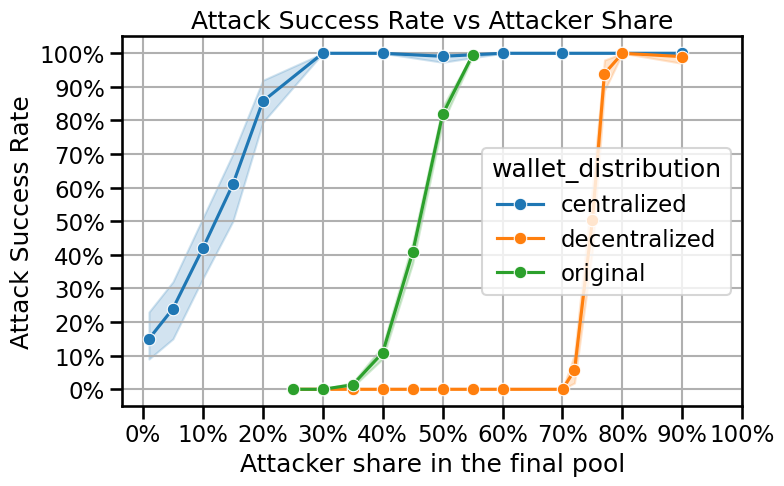

In [67]:
from experiments.analysis_utils.visualization import plot_attack_success_rate
fig = plot_attack_success_rate(combined_timestep_data_df, combined_start_data_df, final_share=True, hue='wallet_distribution')
fig.gca().set_xlabel('Attacker share in the final pool')
fig.gca().set_xticks(np.arange(0, 1.1, 0.1));
fig.gca().set_yticks(np.arange(0, 110, 10));


Text(0.5, 0, 'Added Pool Share')

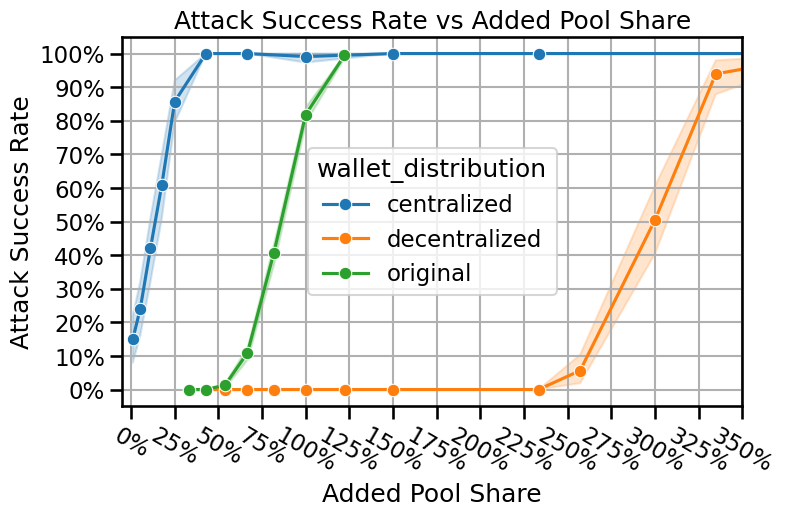

In [82]:
from experiments.analysis_utils.visualization import plot_attack_success_rate
from matplotlib.ticker import FuncFormatter
fig = plot_attack_success_rate(combined_timestep_data_df, combined_start_data_df, final_share=False, hue='wallet_distribution')
fig.gca().set_xticks(np.arange(0, 3.6, 0.25));
# fig.gca().xaxis.set_major_formatter(PercentFormatter)
fig.gca().set_xlim(-0.05, 3.5)
fig.gca().set_yticks(np.arange(0, 110, 10));
fig.gca().tick_params(axis='x', rotation=-30)

fig.gca().set_xlabel('Added Pool Share')


## Group dynamics

In [173]:
path_to_runs = Path("../../results/simulations/actors_labelling_centralized_and_decentralized")
proposal_df_full, start_data_df_full, timestep_data_df_full = read_directory(path_to_runs.resolve(), pass_directory_name=False)

In [174]:
wallet_distribution_map = {
    'decentralized_wallet_distribution.csv': 'decentralized',
    'centralized_wallet_distribution.csv': 'centralized',
    'stETH token distribution  - stETH+wstETH holders.csv': 'original'
}
start_data_df_full['wallet_distribution'] = start_data_df_full['wallet_csv_name'].map(wallet_distribution_map)

In [178]:
proposal_df_full_original, start_data_df_full_original, timestep_data_df_full_original = read_directory(Path("../../results/simulations/actors_labelling_original"), pass_directory_name=False)
start_data_df_full_original['wallet_distribution'] = 'original'

max_run_id = start_data_df_full['run_id'].max()

proposal_df_full_original['run_id'] = proposal_df_full_original['run_id'] + max_run_id
start_data_df_full_original['run_id'] = start_data_df_full_original['run_id'] + max_run_id
timestep_data_df_full_original['run_id'] = timestep_data_df_full_original['run_id'] + max_run_id

timestep_data_df_full = pd.concat([timestep_data_df_full, timestep_data_df_full_original], ignore_index=True)
start_data_df_full = pd.concat([start_data_df_full, start_data_df_full_original], ignore_index=True)
proposal_df_full = pd.concat([proposal_df_full, proposal_df_full_original], ignore_index=True)

In [179]:
from experiments.analysis_utils.metrics import calculate_time_to_first_veto

veto_times = calculate_time_to_first_veto(timestep_data_df_full)
veto_times['veto_success'] = veto_times['time_to_first_veto'].notna()

timestep_data_df_full_with_params = timestep_data_df_full.merge(start_data_df_full[['run_id', 'determining_factor', 'wallet_distribution']], on='run_id')
timestep_data_df_first_timestep = timestep_data_df_full_with_params.loc[timestep_data_df_full_with_params['timestep'] == 1].copy()
timestep_data_df_first_timestep['normal_share']  = timestep_data_df_first_timestep.balance_Normal / timestep_data_df_first_timestep.actors_total_balance
timestep_data_df_first_timestep['quick_share'] = timestep_data_df_first_timestep.balance_Quick / timestep_data_df_first_timestep.actors_total_balance
timestep_data_df_first_timestep['normal_defending_share'] = timestep_data_df_first_timestep.normal_share * timestep_data_df_first_timestep.determining_factor / 100
timestep_data_df_first_timestep['quick_defending_share'] = timestep_data_df_first_timestep.quick_share * timestep_data_df_first_timestep.determining_factor / 100
timestep_data_df_first_timestep['defending_share'] = timestep_data_df_first_timestep.normal_defending_share + timestep_data_df_first_timestep.quick_defending_share
timestep_data_df_first_timestep['defending_share_relative'] = timestep_data_df_first_timestep.defending_share / 0.01
timestep_data_df_first_timestep = timestep_data_df_first_timestep.merge(veto_times, on='run_id')

Optimization terminated successfully.
         Current function value: 0.134365
         Iterations 11
                           Logit Regression Results                           
Dep. Variable:           veto_success   No. Observations:                16330
Model:                          Logit   Df Residuals:                    16328
Method:                           MLE   Df Model:                            1
Date:                Thu, 26 Dec 2024   Pseudo R-squ.:                  0.8048
Time:                        15:56:09   Log-Likelihood:                -2194.2
converged:                       True   LL-Null:                       -11241.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                      -31.6408      0.674    -46.954      0.000     -32.96

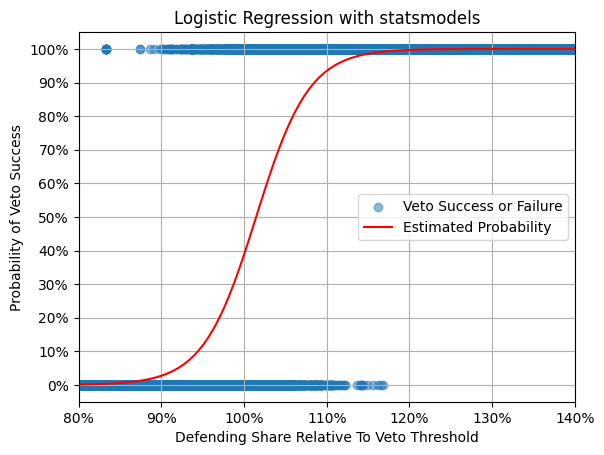

In [186]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from matplotlib.ticker import PercentFormatter

# Extract x and y
x_data = timestep_data_df_first_timestep['defending_share_relative']
y_data = timestep_data_df_first_timestep['veto_success']

# Prepare the data for statsmodels
X = sm.add_constant(x_data)  # Add a constant term for the intercept

# Fit the logistic regression model
model = sm.Logit(y_data, X)
result = model.fit()

# Print the summary of the model
print(result.summary())

# Predict probabilities
# x_fit = np.linspace(x_data.min(), x_data.max(), 100)
x_fit = np.linspace(0.8, 1.4, 100)
X_fit = sm.add_constant(x_fit)
y_prob = result.predict(X_fit)

# Plot the data and the logistic curve
plt.scatter(x_data, y_data, alpha=0.5, label='Veto Success or Failure')
plt.plot(x_fit, y_prob, color='red', label='Estimated Probability')
plt.xlabel('Defending Share Relative To Veto Threshold')
plt.ylabel('Probability of Veto Success')
plt.title('Logistic Regression with statsmodels')
plt.legend()
plt.xlim(0.8, 1.4)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.gca().xaxis.set_major_formatter(PercentFormatter(1))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.grid()

In [181]:
from experiments.analysis_utils.metrics import analyze_veto_timing_by_seals
timestep_data_df_full_with_params = timestep_data_df_full.merge(start_data_df_full, on='run_id')
veto_stats = analyze_veto_timing_by_seals(timestep_data_df_full, start_data_df_full, additional_columns=('wallet_distribution', 'determining_factor'))
veto_stats


veto_rate  \
first_seal_rage_quit_support second_seal_rage_quit_support wallet_distribution determining_factor               
0.01                         0.1                           centralized         0                     0.000000   
                                                                               10                    0.000000   
                                                                               20                    0.000000   
                                                                               30                    0.000000   
                                                                               40                    0.000000   
                                                                               50                    0.000000   
                                                                               60                    0.000000   
                                                                               70                    0.000000   
                                                                               72                    1.886792   
                                                                               75                    8.080808   
                                                                               77                   10.101010   
                                                                               80                   17.000000   
                                                                               90                   57.000000   
                                                                               100                  93.000000   
                                                           decentralized       0                     0.000000   
                                                                               10                    0.000000   
                                                                               20                    0.000000   
                                                                               22                    1.886792   
                                                                               25                   39.393939   
                                                                               27                   78.787879   
                                                                               30                   99.000000   
                                                                               40                  100.000000   
                                                                               50                  100.000000   
                                                                               60                  100.000000   
                                                                               70                  100.000000   
                                                                               80                  100.000000   
                                                                               90                  100.000000   
                                                           original            40                    0.754717   
                                                                               43                    1.320755   
                                                                               46                    5.454545   
                                                                               49                   14.545455   
                                                                               52                   31.616162   
                                                                               55                   53.939394   
                                                                               58                   74.066986   
                                

<Axes: xlabel='determining_factor', ylabel='veto_rate'>

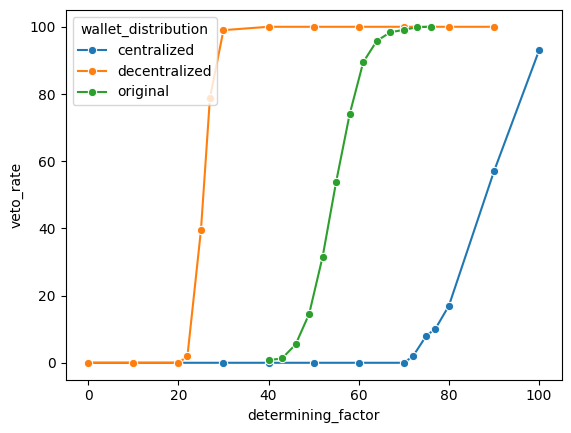

In [182]:
sns.lineplot(data=veto_stats, x='determining_factor', y='veto_rate', hue='wallet_distribution', marker='o')

# Cluster C

## Bribing

In [12]:
wallet_distribution_map = {
    'decentralized_wallet_distribution.csv': 'decentralized',
    'centralized_wallet_distribution.csv': 'centralized',
    'stETH token distribution  - stETH+wstETH holders.csv': 'original'
}
path_to_runs = Path("../../results/simulations/bribed_withdrawal_queue_replacement/")
print(path_to_runs.resolve())
print(path_to_runs.resolve().exists())
proposal_df_full, start_data_df_full, timestep_data_df_full = read_directory(path_to_runs.resolve())
print(len(start_data_df_full))
start_data_df_full['wallet_distribution'] = start_data_df_full['wallet_csv_name'].map(wallet_distribution_map)

/home/rotsker/PycharmProjects/dg-research-revision/results/simulations/bribed_withdrawal_queue_replacement
True
9120


In [13]:
start_data_df_full.modeled_reactions.unique()

array(['Normal', 'Accelerated', 'Slowed'], dtype=object)

In [14]:
# proposal_df_full_original, start_data_df_full_original, timestep_data_df_full_original = read_directory(Path("../../results/simulations/bribed_withdrawal_queue_replacement_normal"), pass_directory_name=False)
# start_data_df_full_original['wallet_distribution'] = 'original'

# max_run_id = start_data_df_full['run_id'].max()

# proposal_df_full_original['run_id'] = proposal_df_full_original['run_id'] + max_run_id
# start_data_df_full_original['run_id'] = start_data_df_full_original['run_id'] + max_run_id
# timestep_data_df_full_original['run_id'] = timestep_data_df_full_original['run_id'] + max_run_id

# timestep_data_df_full = pd.concat([timestep_data_df_full, timestep_data_df_full_original], ignore_index=True)
# start_data_df_full = pd.concat([start_data_df_full, start_data_df_full_original], ignore_index=True)
# proposal_df_full = pd.concat([proposal_df_full, proposal_df_full_original], ignore_index=True)

In [21]:
start_data_df_full['early_responders_count'] = start_data_df_full.quick_and_normal_early_responders_count
start_data_df_full['early_responders_tokens'] = start_data_df_full.quick_and_normal_early_responders_stETH_funds + start_data_df_full.quick_and_normal_early_responders_wstETH_funds
total_funds = timestep_data_df_full.groupby('run_id').actors_total_balance.first()
start_data_df_full['early_responders_tokens_relative'] = (
    start_data_df_full['early_responders_tokens'] / 
    start_data_df_full['run_id'].map(total_funds))
start_data_df_full['amount_needed_to_bribe'] = start_data_df_full['early_responders_tokens_relative'] - 0.01

agg_results = start_data_df_full.groupby(['modeled_reactions', 'wallet_distribution']).agg(
    {
        'early_responders_count': ('median', 'min', 'max'),
        'early_responders_tokens_relative': ('median', 'min', 'max'),
        'amount_needed_to_bribe': ('median', 'min', 'max'),
        'run_id': ('count')
    }
)
agg_results = agg_results.clip(lower=0)
print('Median values for bribing stats in different wallet distributions:')
agg_results

Median values for bribing stats in different wallet distributions:


early_responders_count            \
                                                      median  min  max   
modeled_reactions wallet_distribution                                    
Accelerated       centralized                          349.0  302  408   
                  decentralized                        317.0  273  371   
                  original                             331.0  288  393   
Normal            centralized                          262.0  218  316   
                  decentralized                        237.0  192  288   
                  original                             248.0  205  305   
Slowed            centralized                          174.0  139  219   
                  decentralized                        158.0  125  197   
                  original                             165.0  131  211   

                                      early_responders_tokens_relative  \
                                                                median   
modeled_reactions wallet_distribution                                    
Accelerated       centralized                                 0.015152   
                  decentralized                               0.052567   
                  original                                    0.024640   
Normal            centralized                                 0.011324   
                  decentralized                               0.039461   
                  original                                    0.018459   
Slowed            centralized                                 0.007550   
                  decentralized                               0.026258   
                  original                                    0.012266   

                                                           \
                                            min       max   
modeled_reactions wallet_distribution                       
Accelerated       centralized          0.011608  0.019777   
                  decentralized        0.044876  0.063427   
                  original             0.018977  0.031971   
Normal            centralized          0.007906  0.014468   
                  decentralized        0.032690  0.048953   
                  original             0.013418  0.024005   
Slowed            centralized          0.004821  0.011274   
                  decentralized        0.019894  0.032283   
                  original             0.008421  0.016113   

                                      amount_needed_to_bribe            \
                                                      median       min   
modeled_reactions wallet_distribution                                    
Accelerated       centralized                       0.005152  0.001608   
                  decentralized                     0.042567  0.034876   
                  original                          0.014640  0.008977   
Normal            centralized                       0.001324  0.000000   
                  decentralized                     0.029461  0.022690   
                  original                          0.008459  0.003418   
Slowed            centralized                       0.000000  0.000000   
                  decentralized                     0.016258  0.009894   
                  original                          0.002266  0.000000   

                                                run_id  
                                            max  count  
modeled_reactions wallet_distribution                   
Accelerated       centralized          0.009777    990  
                  decentralized        0.053427    990  
                  original             0.021971    990  
Normal            centralized          0.004468   1060  
                  decentralized        0.038953   1060  
                  original             0.014005   1060  
Slowed            centralized          0.001274    990  
                  decentralized        0.022283    990  
           

In [20]:
agg_results = start_data_df_full.groupby(['wallet_distribution', 'modeled_reactions']).agg(
    {
        'early_responders_count': ('median', 'min', 'max'),
        'early_responders_tokens_relative': ('median', 'min', 'max'),
        'amount_needed_to_bribe': ('median', 'min', 'max'),
        'run_id': ('count')
    }
)
agg_results.clip(lower=0)

early_responders_count            \
                                                      median  min  max   
wallet_distribution modeled_reactions                                    
centralized         Accelerated                        349.0  302  408   
                    Normal                             262.0  218  316   
                    Slowed                             174.0  139  219   
decentralized       Accelerated                        317.0  273  371   
                    Normal                             237.0  192  288   
                    Slowed                             158.0  125  197   
original            Accelerated                        331.0  288  393   
                    Normal                             248.0  205  305   
                    Slowed                             165.0  131  211   

                                      early_responders_tokens_relative  \
                                                                median   
wallet_distribution modeled_reactions                                    
centralized         Accelerated                               0.015152   
                    Normal                                    0.011324   
                    Slowed                                    0.007550   
decentralized       Accelerated                               0.052567   
                    Normal                                    0.039461   
                    Slowed                                    0.026258   
original            Accelerated                               0.024640   
                    Normal                                    0.018459   
                    Slowed                                    0.012266   

                                                           \
                                            min       max   
wallet_distribution modeled_reactions                       
centralized         Accelerated        0.011608  0.019777   
                    Normal             0.007906  0.014468   
                    Slowed             0.004821  0.011274   
decentralized       Accelerated        0.044876  0.063427   
                    Normal             0.032690  0.048953   
                    Slowed             0.019894  0.032283   
original            Accelerated        0.018977  0.031971   
                    Normal             0.013418  0.024005   
                    Slowed             0.008421  0.016113   

                                      amount_needed_to_bribe            \
                                                      median       min   
wallet_distribution modeled_reactions                                    
centralized         Accelerated                     0.005152  0.001608   
                    Normal                          0.001324  0.000000   
                    Slowed                          0.000000  0.000000   
decentralized       Accelerated                     0.042567  0.034876   
                    Normal                          0.029461  0.022690   
                    Slowed                          0.016258  0.009894   
original            Accelerated                     0.014640  0.008977   
                    Normal                          0.008459  0.003418   
                    Slowed                          0.002266  0.000000   

                                                run_id  
                                            max  count  
wallet_distribution modeled_reactions                   
centralized         Accelerated        0.009777    990  
                    Normal             0.004468   1060  
                    Slowed             0.001274    990  
decentralized       Accelerated        0.053427    990  
                    Normal             0.038953   1060  
                    Slowed             0.022283    990  
original            Accelerated        0.021971    990  
                    Normal             0.014005   1060  
           

We can see that bribing amount is much higher than in case of original token distribution. It is even higher than with fast reactions.

# Wallet analysis

In [5]:
from experiments.analysis_utils.wallets import add_total_token_share, count_n_wallets_threshold, get_token_array, count_distinct_first_wallets

def mode(a):
    u, c = np.unique(a, return_counts=True)
    return u[c.argmax()]

wallet_distribution_map = {
    'decentralized_wallet_distribution.csv': 'decentralized',
    'centralized_wallet_distribution.csv': 'centralized',
    'stETH token distribution  - stETH+wstETH holders.csv': 'original'
}

wallet_df_list = []
for p in Path('../../data').glob('*.csv'):
    wallet_df = pd.read_csv(p)
    wallet_df = add_total_token_share(wallet_df)
    wallet_df['wallet_distribution'] = wallet_distribution_map[p.name]
    wallet_df_list.append(wallet_df)
wallet_df_combined = pd.concat(wallet_df_list, ignore_index=True)

In [24]:
wallet_df = wallet_df_combined[wallet_df_combined['wallet_distribution'] == 'centralized']
print((wallet_df[wallet_df['type'].isin(['Private', 'No label'])].total >= 3000).sum())
print((wallet_df[wallet_df['type'].isin(['Private', 'No label'])].total < 3000).sum())
centralized_can_be_active = (wallet_df[wallet_df['type'].isin(['Private', 'No label'])].total < 3000).sum()

137
1667


In [23]:
wallet_df = wallet_df_combined[wallet_df_combined['wallet_distribution'] == 'original']
print((wallet_df[wallet_df['type'].isin(['Private', 'No label'])].total >= 3000).sum())
print((wallet_df[wallet_df['type'].isin(['Private', 'No label'])].total < 3000).sum())
original_can_be_active = (wallet_df[wallet_df['type'].isin(['Private', 'No label'])].total < 3000).sum()

219
1585


In [25]:
centralized_can_be_active / original_can_be_active

np.float64(1.0517350157728707)

In [26]:
237 * 1.05

248.85000000000002

In [13]:
wallet_basic_stats = wallet_df_combined.groupby('wallet_distribution').agg(
    {
        'total_token_share': ('mean', 'median')
    }
)
wallet_basic_stats.reindex(['centralized', 'original', 'decentralized'])


total_token_share          
                                 mean    median
wallet_distribution                            
centralized                  0.050352  0.003030
original                     0.050352  0.007419
decentralized                0.050352  0.017109

In [251]:
import pandas as pd
import numpy as np

wallet_types = ['Private', 'Other', 'No label']
thresholds = np.array([.5, .75, 1., 1.25, 1.5, 1.75, 2.])

# Define the group sizes you want to calculate
group_sizes = [1, 2, 3, 4]  # You can change this to [1, 2, 3, 5] or any other combination

# Prepare a list to hold the data for the DataFrame
data = []

for wallet_distribution, group_df in wallet_df_combined.groupby('wallet_distribution'):
    for threshold in thresholds:
        # Initialize a dictionary to hold the counts for each group size
        counts = {'wallet_distribution': wallet_distribution, 'threshold': threshold}
        
        # Calculate the counts for each group size
        for size in group_sizes:
            combinations, _ = count_n_wallets_threshold(group_df, wallet_types, threshold, size)
            distinct_first_wallets = count_distinct_first_wallets(group_df, wallet_types, threshold, size)
            # Use dynamic key names based on the size
            counts[f'group_of_{size}_combinations'] = combinations
            counts[f'group_of_{size}_distinct_first_wallets'] = distinct_first_wallets
        # Append the counts dictionary to the data list
        data.append(counts)

# Create a DataFrame from the data list
df = pd.DataFrame(data)

In [252]:
df

,wallet_distribution,threshold,group_of_1_combinations,group_of_1_distinct_first_wallets,group_of_2_combinations,group_of_2_distinct_first_wallets,group_of_3_combinations,group_of_3_distinct_first_wallets,group_of_4_combinations,group_of_4_distinct_first_wallets
0,centralized,0.50,4,4,7727,16,7509318,21,4817176754,25
1,centralized,0.75,2,2,3644,6,3323039,15,2022249427,18
2,centralized,1.00,1,1,1870,3,1751862,7,1097046338,14
3,centralized,1.25,1,1,1811,2,1640313,5,990964239,9
4,centralized,1.50,0,0,32,1,66654,3,69156133,5
5,centralized,1.75,0,0,7,1,13469,2,13069152,4
6,centralized,2.00,0,0,1,1,1970,1,1957638,2
7,decentralized,0.50,6,6,11627,18,11939230,29,8816776454,42
8,decentralized,0.75,2,2,3772,10,3648030,17,2425499933,25
9,decentralized,1.00,2,2,3620,5,3281280,13,1993000693,17


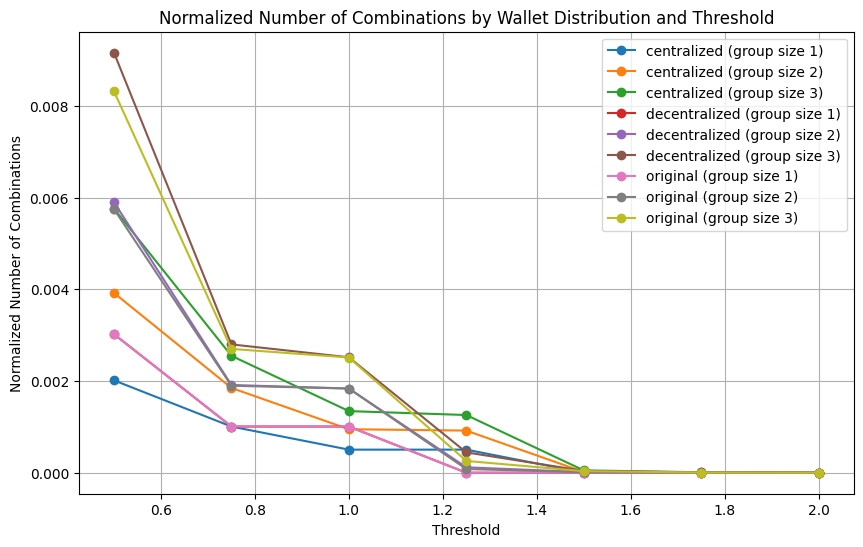

In [254]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import comb

# Example DataFrame structure
# df = pd.DataFrame({
#     'wallet_distribution': ['centralized', 'centralized', 'decentralized', ...],
#     'threshold': [0.5, 0.75, 0.5, ...],
#     'group_of_1_combinations': [10, 15, 8, ...],
#     'group_of_2_combinations': [5, 10, 4, ...],
#     ...
# })

# Define the group sizes you want to plot
group_sizes = [1, 2, 3]  # Example group sizes

# Calculate the maximum possible number of combinations for each wallet distribution and group size
max_possible_combinations = {}
for wallet_distribution in df['wallet_distribution'].unique():
    token_array_length = len(wallet_df_combined[wallet_df_combined['wallet_distribution'] == wallet_distribution])
    for size in group_sizes:
        max_possible_combinations[(wallet_distribution, size)] = comb(token_array_length, size)

# Normalize the number of combinations for each group size
for size in group_sizes:
    column_name = f'group_of_{size}_combinations'
    df[f'normalized_{column_name}'] = df.apply(
        lambda row: row[column_name] / max_possible_combinations[(row['wallet_distribution'], size)],
        axis=1
    )

# Plot the data
plt.figure(figsize=(10, 6))
for wallet_distribution in df['wallet_distribution'].unique():
    for size in group_sizes:
        column_name = f'normalized_group_of_{size}_combinations'
        subset = df[df['wallet_distribution'] == wallet_distribution]
        plt.plot(subset['threshold'], subset[column_name], marker='o', label=f'{wallet_distribution} (group size {size})')

plt.xlabel('Threshold')
plt.ylabel('Normalized Number of Combinations')
plt.title('Normalized Number of Combinations by Wallet Distribution and Threshold')
plt.legend()
plt.grid(True)
plt.show()

<>:26: SyntaxWarning: invalid escape sequence '\d'
<>:26: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_14226/174474161.py:26: SyntaxWarning: invalid escape sequence '\d'
  melted_df['group_size'] = melted_df['group_size'].str.extract('(\d+)').astype(int)


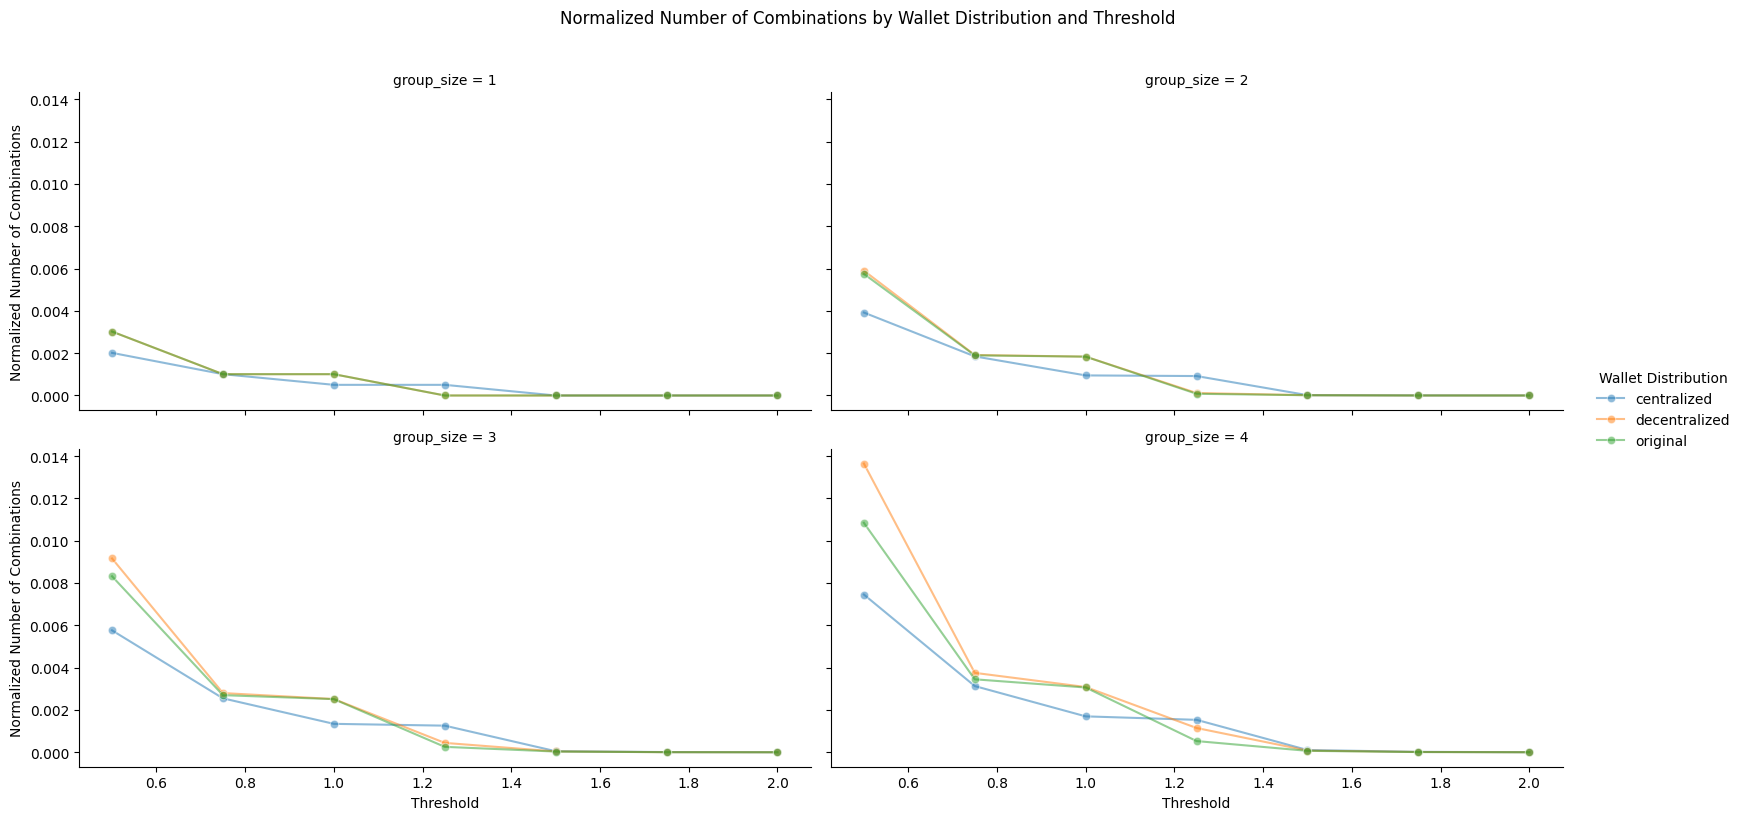

In [266]:
from scipy.special import comb

group_sizes = [1, 2, 3, 4]  # Example group sizes

# Calculate the maximum possible number of combinations for each wallet distribution and group size
max_possible_combinations = {}
for wallet_distribution in df['wallet_distribution'].unique():
    token_array_length = len(wallet_df_combined[wallet_df_combined['wallet_distribution'] == wallet_distribution])
    for size in group_sizes:
        max_possible_combinations[(wallet_distribution, size)] = comb(token_array_length, size)

# Normalize the number of combinations for each group size
for size in group_sizes:
    column_name = f'group_of_{size}_combinations'
    df[f'normalized_{column_name}'] = df.apply(
        lambda row: row[column_name] / max_possible_combinations[(row['wallet_distribution'], size)],
        axis=1
    )

# Melt the DataFrame for seaborn
melted_df = df.melt(id_vars=['wallet_distribution', 'threshold'], 
                    value_vars=[f'normalized_group_of_{size}_combinations' for size in group_sizes],
                    var_name='group_size', value_name='normalized_combinations')

# Extract group size from the column name
melted_df['group_size'] = melted_df['group_size'].str.extract('(\d+)').astype(int)

# Plot using seaborn FacetGrid
g = sns.FacetGrid(melted_df, col='group_size', col_wrap=2, hue='wallet_distribution', height=4, aspect=2, margin_titles=True, sharex=True, sharey=True)
g.map(sns.lineplot, 'threshold', 'normalized_combinations', marker='o', alpha=0.5).add_legend(title='Wallet Distribution')

g.set_axis_labels('Threshold', 'Normalized Number of Combinations')
g.set_titles(row_template='Group Size: {row_name}')
g.fig.suptitle('Normalized Number of Combinations by Wallet Distribution and Threshold', y=1.02)
# g.set(ylim=(0, 1))  # Assuming normalization results in values between 0 and 1
g.tight_layout()
plt.show()

<>:9: SyntaxWarning: invalid escape sequence '\d'
<>:9: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_14226/3365722683.py:9: SyntaxWarning: invalid escape sequence '\d'
  melted_df['group_size'] = melted_df['group_size'].str.extract('(\d+)').astype(int)


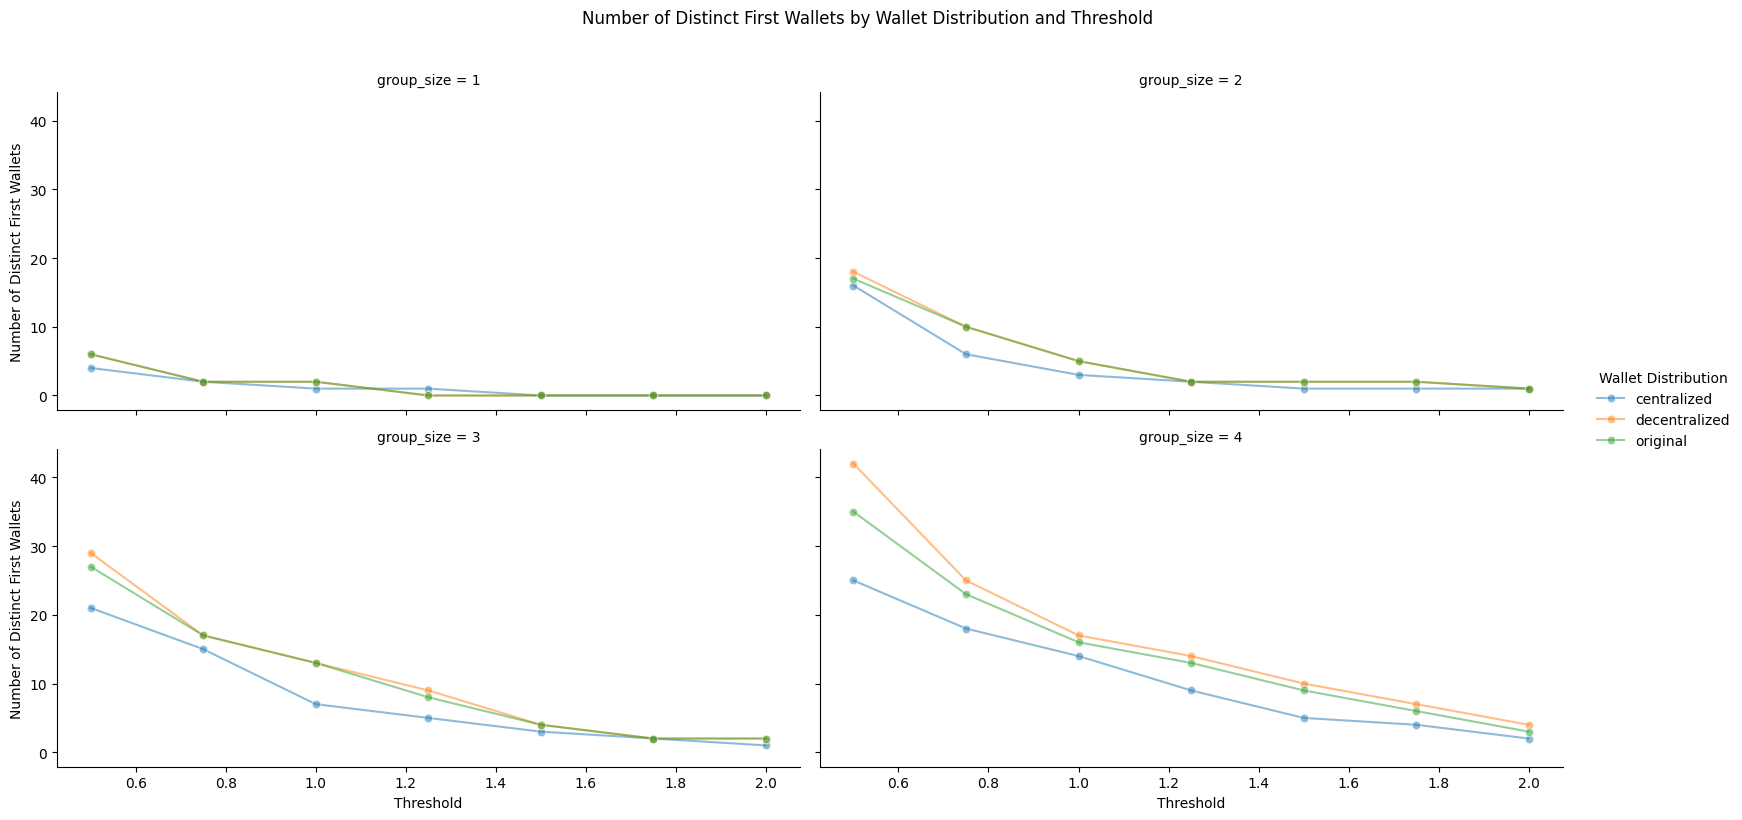

In [267]:
group_sizes = [1, 2, 3, 4]  # Example group sizes

# Melt the DataFrame for seaborn
melted_df = df.melt(id_vars=['wallet_distribution', 'threshold'], 
                    value_vars=[f'group_of_{size}_distinct_first_wallets' for size in group_sizes],
                    var_name='group_size', value_name='distinct_first_wallets')

# Extract group size from the column name
melted_df['group_size'] = melted_df['group_size'].str.extract('(\d+)').astype(int)

# Plot using seaborn FacetGrid
g = sns.FacetGrid(melted_df, col='group_size', col_wrap=2, hue='wallet_distribution', height=4, aspect=2, margin_titles=True)
g.map(sns.lineplot, 'threshold', 'distinct_first_wallets', marker='o', alpha=0.5).add_legend(title='Wallet Distribution')

g.set_axis_labels('Threshold', 'Number of Distinct First Wallets')
g.set_titles(row_template='Group Size: {row_name}')
g.fig.suptitle('Number of Distinct First Wallets by Wallet Distribution and Threshold', y=1.02)
g.tight_layout()
plt.show()

In [268]:
wallet_df_combined[wallet_df_combined['wallet_distribution'] == 'centralized'].total.sum() * 0.1

np.float64(899641.6817706289)